# Making a dataset from a movie (.avi)

The models can be used to predict any type of temporal sequence in two dimensions, normally these type of data are videos. So, in this example I show how to convert a video into the dataset shapes you need to use it.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

All these functions are coded for the KTH dataset, but could be easily adapted to other videos.

In [2]:
def get_frames(file):
    
    H_crop = W_crop = 120 # where to crop the movie frames (if they are not squares)
    H = W = 64         # height and width of the final frames
    pixel_th = 180        # to skip frames with 'not relevant' content
    
    vidcap = cv2.VideoCapture(file)
    success, image = vidcap.read()
    # One iteration over the frames to count those that are relevant. 
    # Just to create the 'frames' array at once and avoid using append 
    # and be time-memory inneficient.
    # This could be HIGHLY optimize
    count = 0
    while success:
        res = cv2.resize(image[:H_crop,:W_crop,0], dsize=(H, W), interpolation=cv2.INTER_AREA)
        inv = np.invert(res)
        if np.max(inv) > pixel_th:
            count += 1
        success,image = vidcap.read()

    # Define the empty array
    frames = np.zeros((1,count, H, W))
    # Iterate again saving the frames
    vidcap = cv2.VideoCapture(file)
    success,image = vidcap.read()
    i = 0
    while success:
        res = cv2.resize(image[:H_crop,:W_crop,0], dsize=(H, W), interpolation=cv2.INTER_AREA)
        inv = np.invert(res)
        if np.max(inv) > pixel_th:
            frames[0,i] = inv
            i += 1
        success,image = vidcap.read()
    return frames

def reshape_indexes(old_length, new_length):
    '''return N indexes from original sequence to create N shorter sequences'''
    index = []
    i=0
    while i+new_length <= old_length:# i in range(int(total_length/groups_length)):
        index.append(i)
        i = i+8
    return [int(j) for j in index]

def reshape(data, new_length):
    old_length = data.shape[1]
    new_data = np.zeros([1,new_length,data.shape[2],data.shape[3]], dtype='uint8')
    for index in reshape_indexes(old_length, new_length):
        new_data = np.append(new_data,data[:,index:index+new_length],0)
    return np.delete(new_data,0,0)

def create_dataset(file):
    frames = get_frames(file)
    #print(frames.shape)
    return reshape(frames, 32)

### Create the dataset

In [3]:
directory = '../data/video_datasets/KTH_walking'
dataset = np.zeros((1,32,64,64))
for file in sorted(os.listdir(directory)):    
    if not file.endswith('avi'): continue
    dataset_aux = create_dataset(directory+'/'+file)
    #print(dataset_aux.shape)
    dataset = np.concatenate((dataset,dataset_aux), axis=0)
dataset = np.delete(dataset,0,0)
dataset.shape

(67, 32, 64, 64)

Save it

In [4]:
np.save(directory+'/dataset.npy',dataset)

## Plot the dataset samples

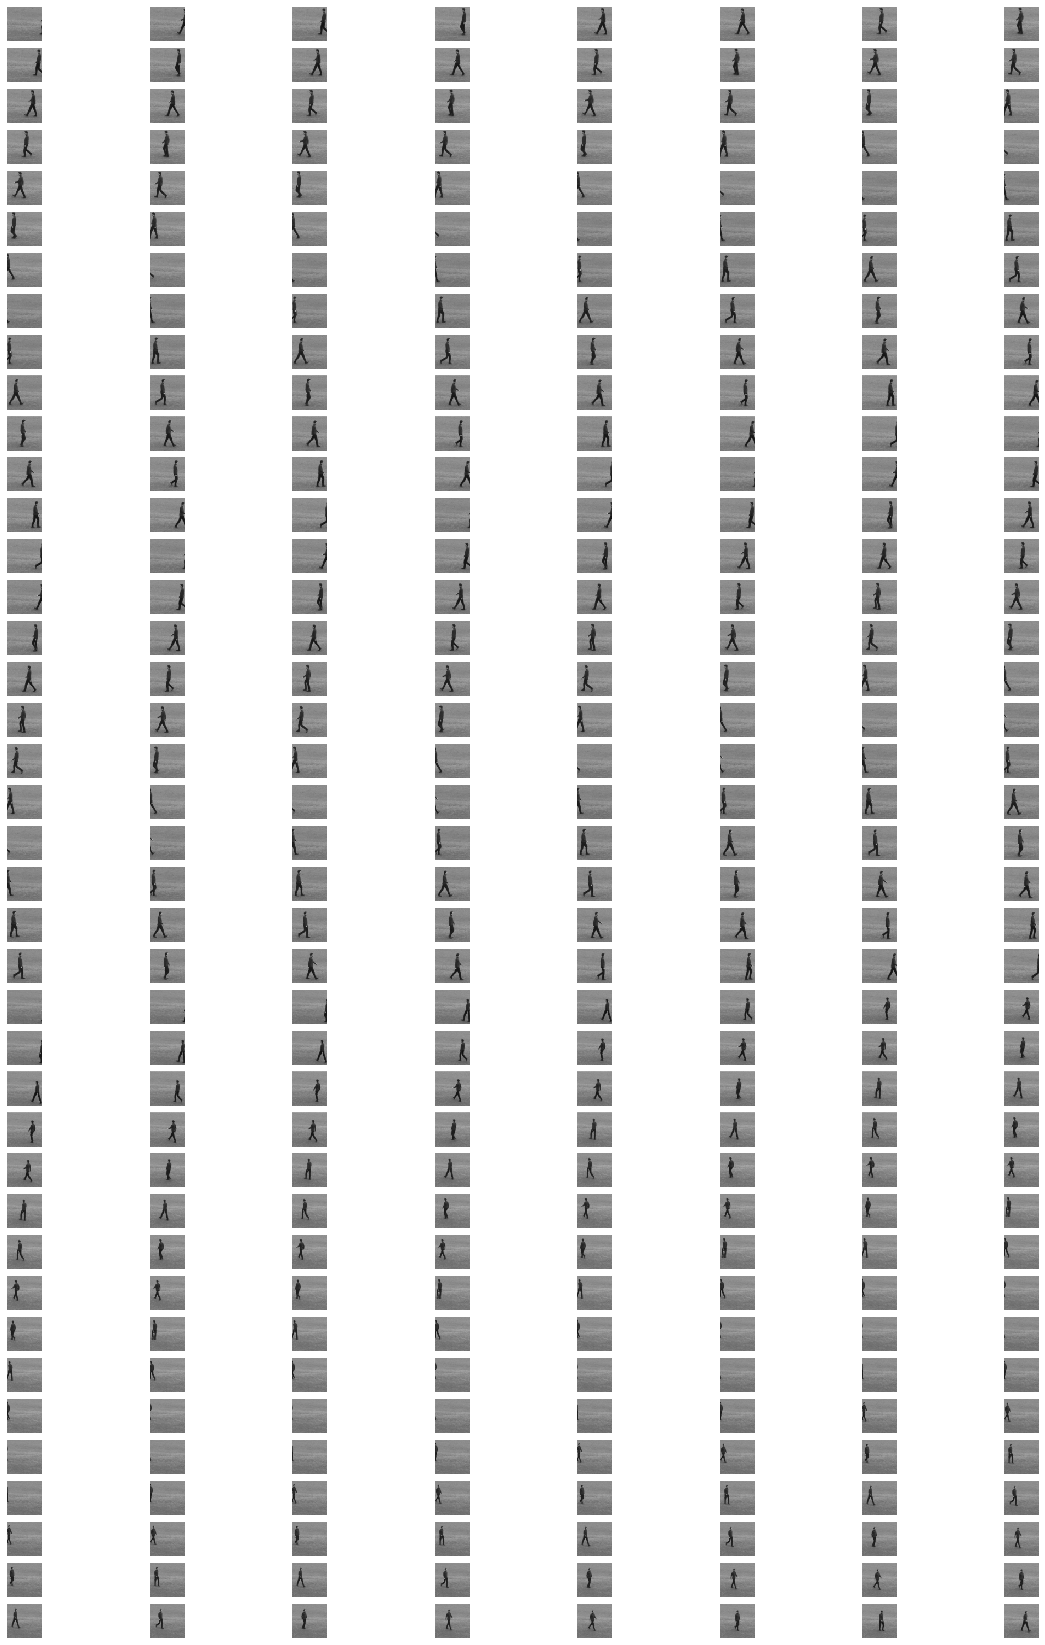

In [5]:
plt.figure(figsize=(20,30))
n = len(dataset)
for i in range(40):
    for j in range(8):
        plt.subplot(40,8,i*8+j+1)
        plt.imshow(dataset[i,j*4], vmin=0, vmax=255, cmap='binary')
        plt.axis('off')
    